Processing fold #1


C:\Users\STUDENT\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Processing fold #2
Processing fold #3
Processing fold #4


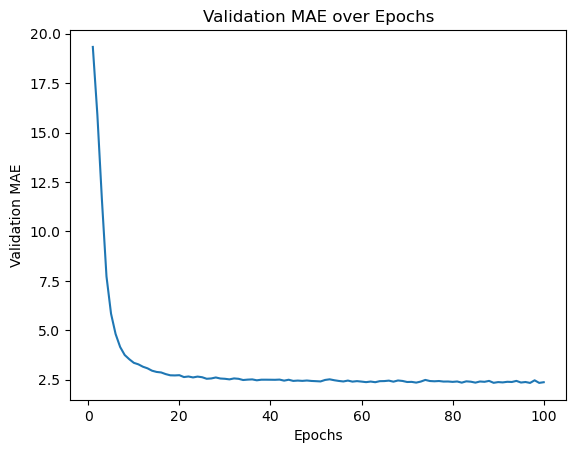

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 14.3234 - mae: 2.5364 
Test MAE: 2.774


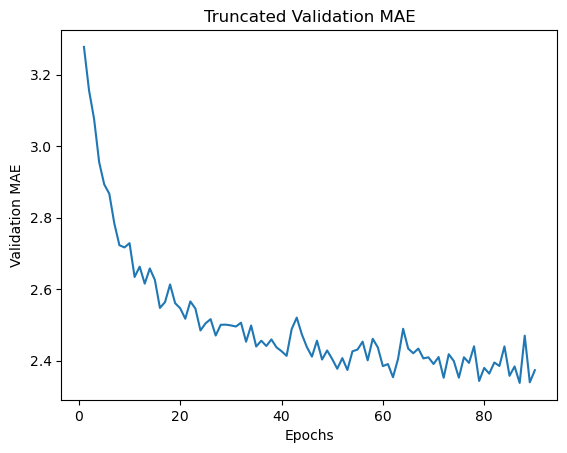

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 13.3553 - mae: 2.5496
Test MAE after 130 epochs: 2.711


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras import models, layers

# Load data
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Normalize data
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

# Build model function
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))  # Regression output
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

# K-fold cross-validation
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_mae_histories = []

for i in range(k):
    print(f'Processing fold #{i+1}')
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)

    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

# Average MAE across folds
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]

# Plot validation MAE
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.title('Validation MAE over Epochs')
plt.show()

# Train final model
optimal_epochs = 80
final_model = build_model()
final_model.fit(train_data, train_targets, epochs=optimal_epochs,
                batch_size=16, verbose=0)

# Evaluate on test data
test_mse_score, test_mae_score = final_model.evaluate(test_data, test_targets)
print(f"Test MAE: {test_mae_score:.3f}")

# Plot truncated MAE (after epoch 10)
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.title("Truncated Validation MAE")
plt.show()

# Optional: Train longer and evaluate
model = build_model()
model.fit(train_data, train_targets, epochs=130, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print(f"Test MAE after 130 epochs: {test_mae_score:.3f}")
